In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from patsy import dmatrices
from scipy import stats



In [25]:
senic_df = pd.read_csv('./senic.csv')
senic_df = senic_df.drop(['id'], axis=1)

senic_df = senic_df[['infection_risk','stay_length', 'age','culture_ratio', 'chest_ratio',
                     'bed_count', 'med_school', 'region', 'avg_daily_census', 'nurse_count',
                     'available_services']]

senic_df.describe().round(2)

,infection_risk,stay_length,age,culture_ratio,chest_ratio,bed_count,med_school,region,avg_daily_census,nurse_count,available_services
count,113.00,113.00,113.00,113.00,113.00,113.00,113.00,113.00,113.00,113.00,113.00
mean,4.35,9.65,53.23,15.79,81.63,252.17,1.85,2.36,191.37,173.25,43.16
std,1.34,1.91,4.46,10.23,19.36,192.84,0.36,1.01,153.76,139.27,15.20
min,1.30,6.70,38.80,1.60,39.60,29.00,1.00,1.00,20.00,14.00,5.70
25%,3.70,8.34,50.90,8.40,69.50,106.00,2.00,2.00,68.00,66.00,31.40
50%,4.40,9.42,53.20,14.10,82.30,186.00,2.00,2.00,143.00,132.00,42.90
75%,5.20,10.47,56.20,20.30,94.10,312.00,2.00,3.00,252.00,218.00,54.30
max,7.80,19.56,65.90,60.50,133.50,835.00,2.00,4.00,791.00,656.00,80.00


In [26]:
# do we have enough data for the number of predictor variables
n = senic_df.shape[0]
params = senic_df.shape[1]-1
n>params*6


True

In [27]:
def normality_output(data):
    shapiro_output = stats.shapiro(data)
    shapiro_stat = shapiro_output[0]
    shapiro_p = shapiro_output[1]
    print("Shapiro Statistic: {:.3f}".format(shapiro_stat))
    if shapiro_p < 0.05:
        print('Data is non-normal with p-value: {:.5f}'.format(shapiro_p))
    else:
        print('Data appears to be normal with p-value: {:.3f}'.format(shapiro_p))
    return shapiro_output

def qq_plot_maker(df, col):

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    prob = stats.probplot(df[col], dist=stats.norm, plot=ax1)
    plt.show()
    
def univariate_plot_maker(df, y_col, x_col, y_col_title, x_col_title):
    df[x_col].plot(kind='hist').set_title(x_col_title);
    qq_plot_maker(df, x_col)
    ax = df.plot(kind='scatter', x=x_col, y=y_col);
    ax.set_title(x_col_title+' vs. ' + y_col_title);

## Infection Risk

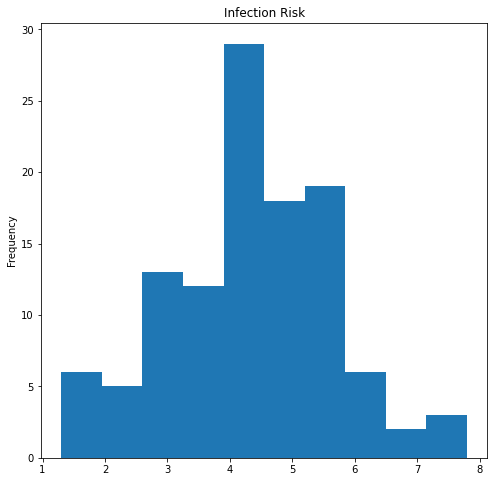

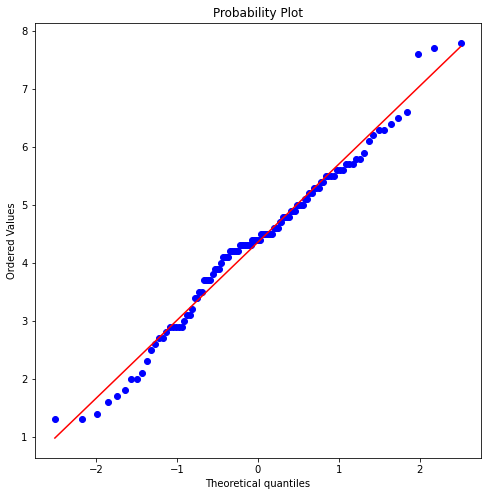

Shapiro Statistic: 0.982
Data appears to be normal with p-value: 0.134


In [28]:
plt.rcParams["figure.figsize"] = (8, 8)

senic_df['infection_risk'].plot(kind='hist').set_title('Infection Risk');
qq_plot_maker(senic_df, 'infection_risk')

norm_output = normality_output(senic_df['infection_risk'])

## Stay Length

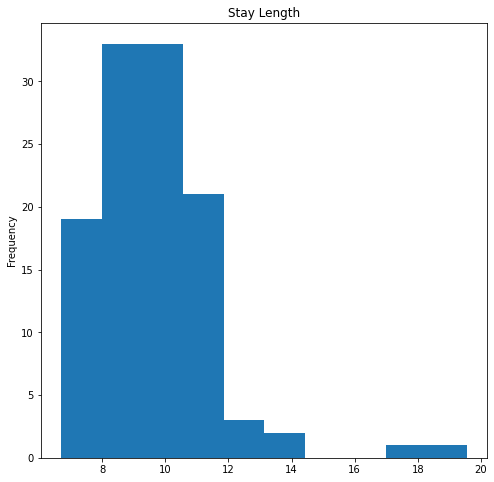

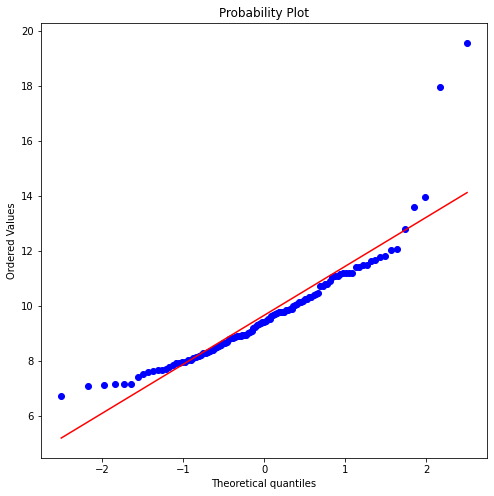

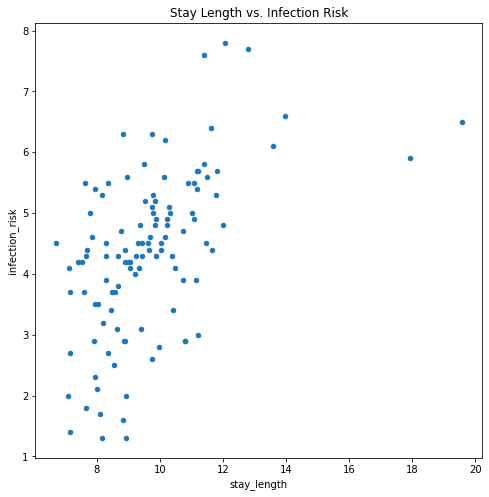

In [29]:
univariate_plot_maker(senic_df, 'infection_risk', 'stay_length', 'Infection Risk', 'Stay Length')

## Age

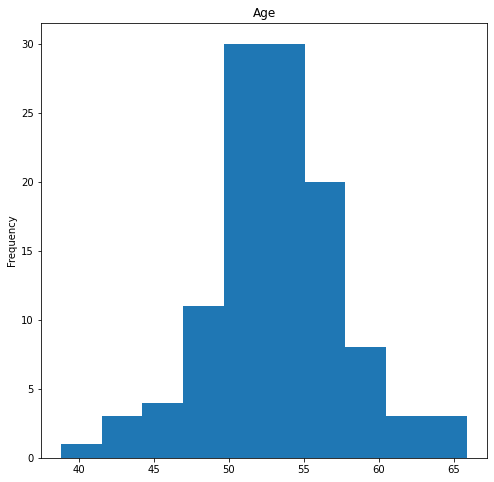

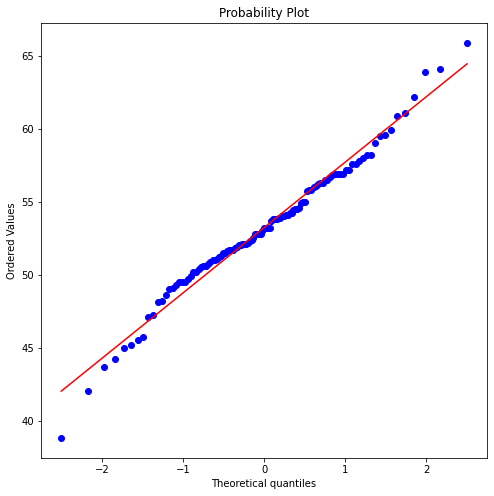

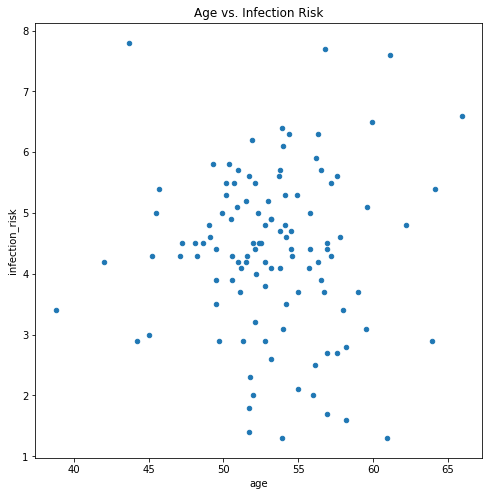

In [30]:
univariate_plot_maker(senic_df, 'infection_risk', 'age', 'Infection Risk', 'Age')

## Culture Ratio

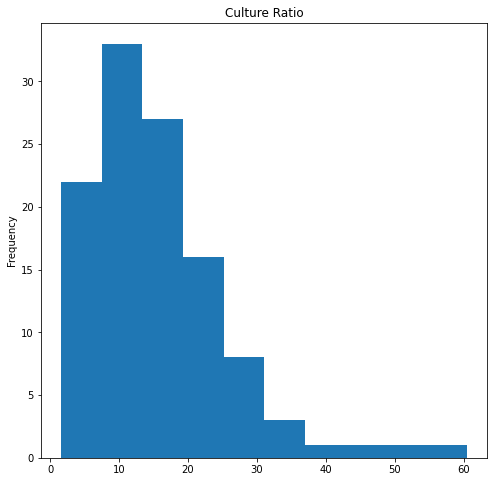

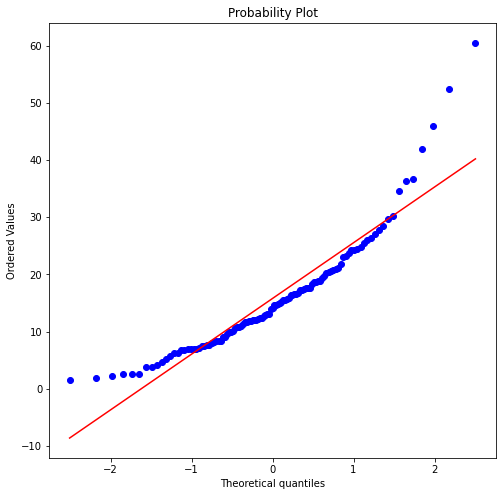

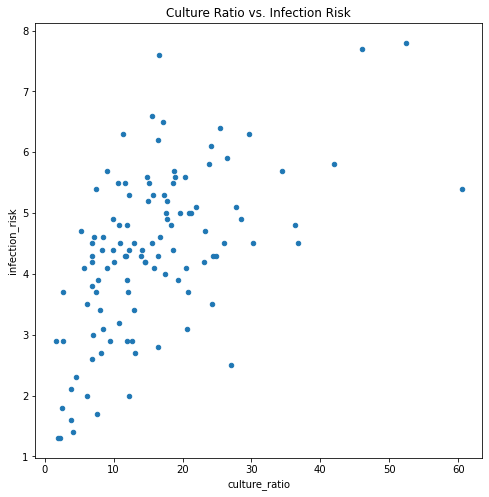

In [31]:
univariate_plot_maker(senic_df, 'infection_risk', 'culture_ratio', 'Infection Risk', 'Culture Ratio')

## Chest Ratio

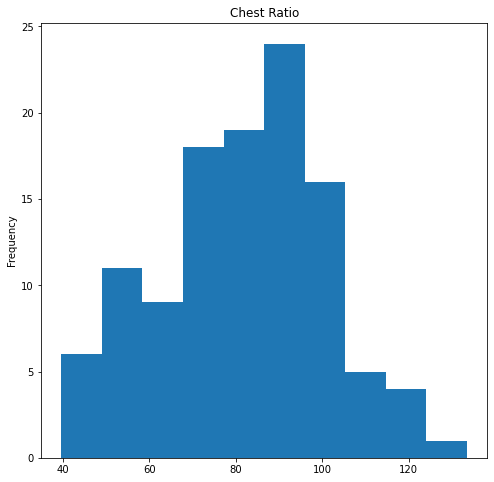

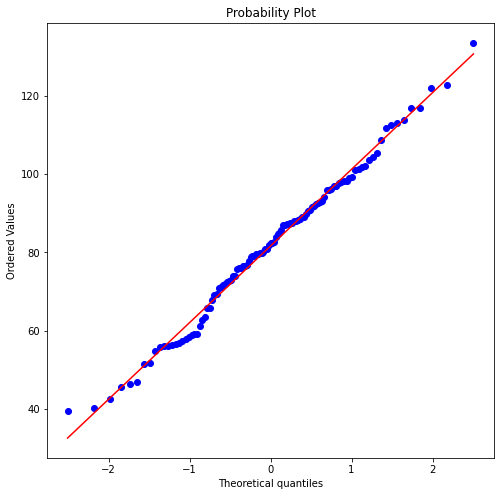

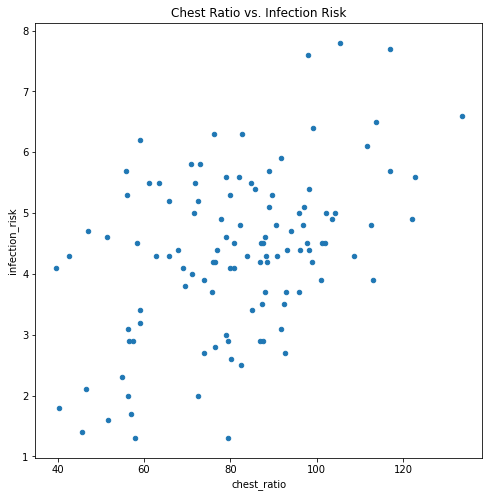

In [32]:
univariate_plot_maker(senic_df, 'infection_risk', 'chest_ratio', 'Infection Risk', 'Chest Ratio')

## Bed Count

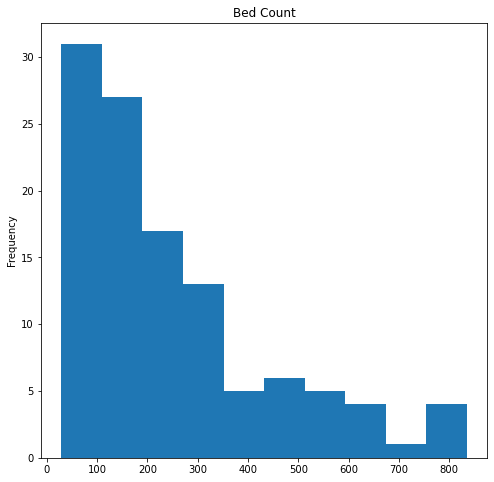

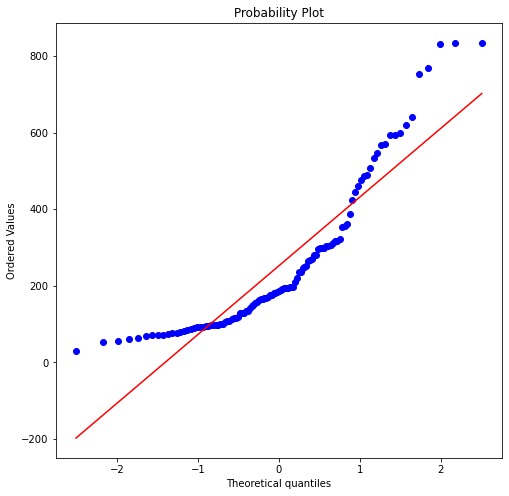

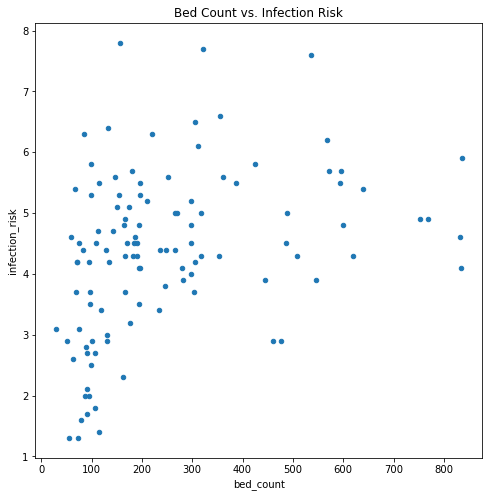

In [33]:
univariate_plot_maker(senic_df, 'infection_risk', 'bed_count', 'Infection Risk', 'Bed Count')

## Med School

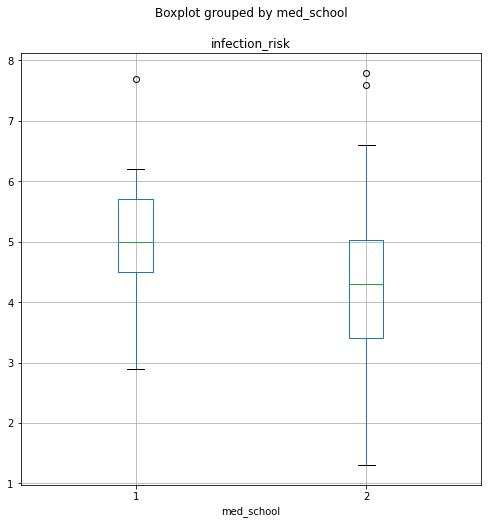

In [34]:

senic_df['med_school'].value_counts()

senic_df.boxplot('infection_risk', by='med_school');



## Region

3    37
2    32
1    28
4    16
Name: region, dtype: int64

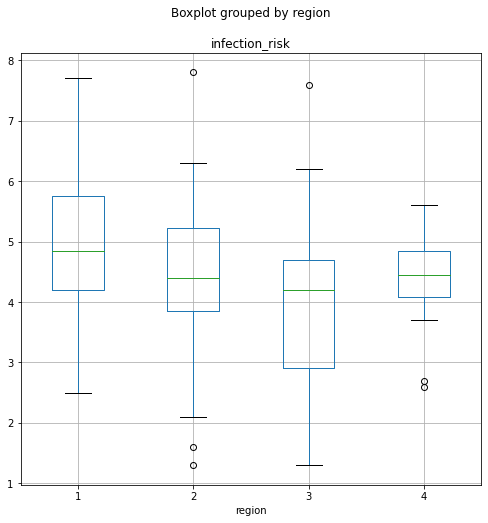

In [35]:
senic_df.boxplot('infection_risk', by='region');

senic_df['region'].value_counts()

## Daily Census

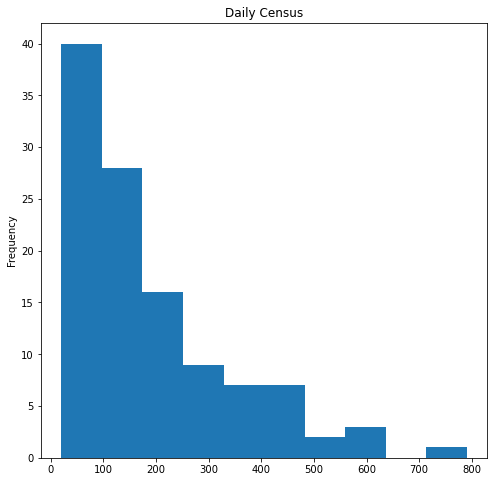

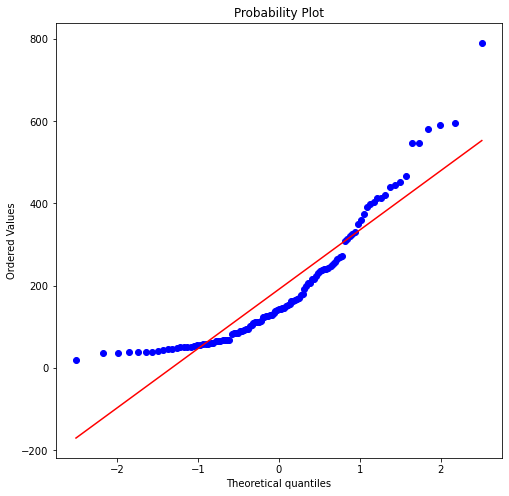

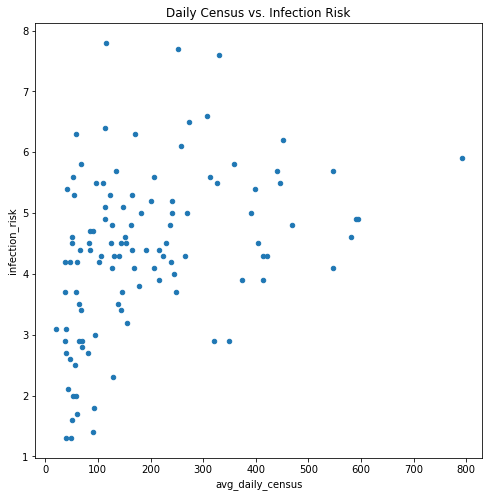

In [36]:
univariate_plot_maker(senic_df, 'infection_risk', 'avg_daily_census', 'Infection Risk', 'Daily Census')

## Nurse Count

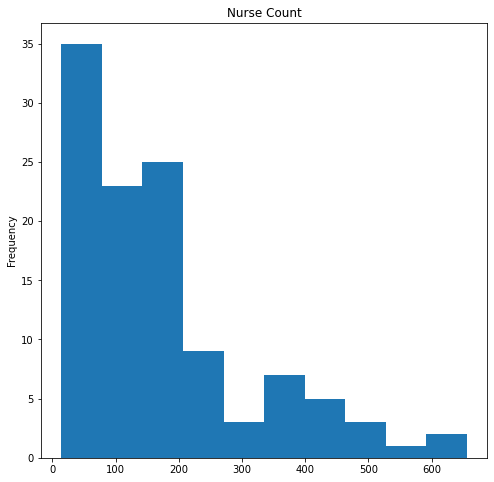

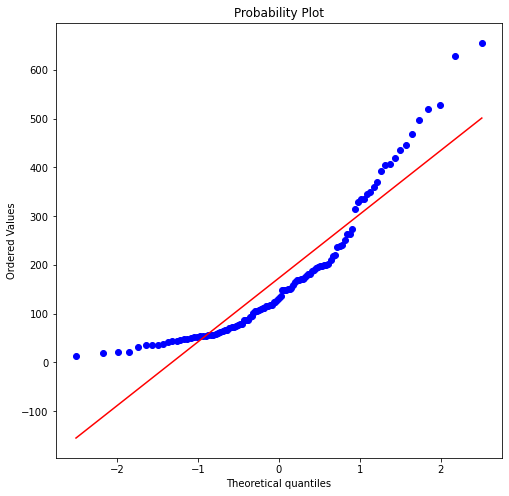

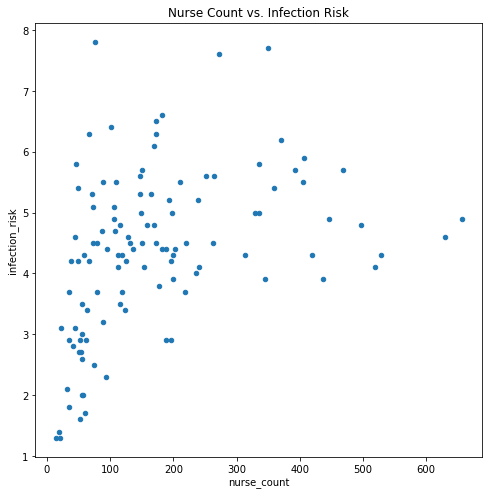

In [37]:
univariate_plot_maker(senic_df, 'infection_risk', 'nurse_count', 'Infection Risk', 'Nurse Count')

## Available Services

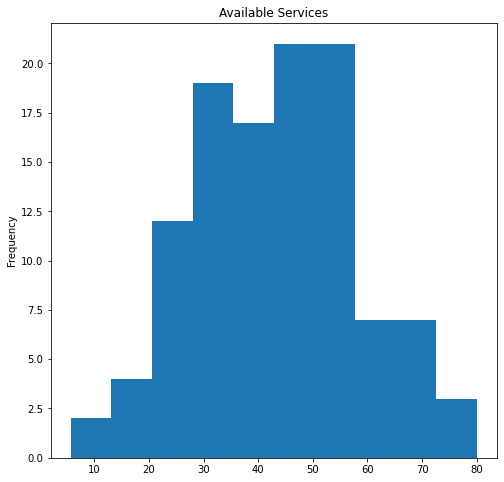

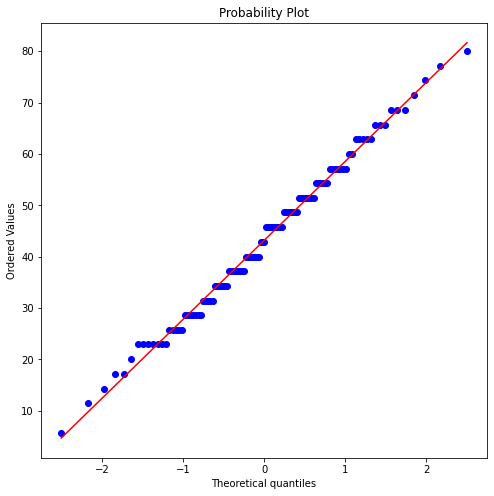

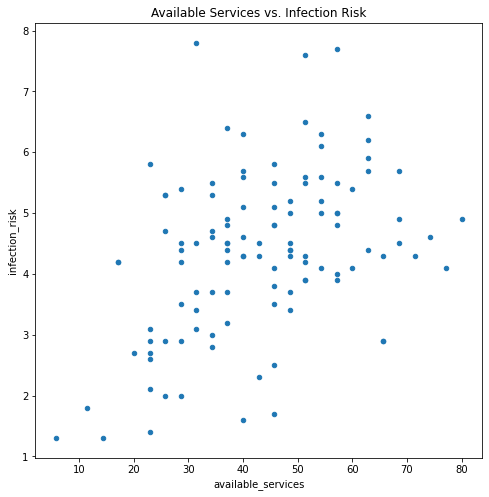

In [38]:
univariate_plot_maker(senic_df, 'infection_risk', 'available_services', 'Infection Risk', 'Available Services')

## Collinerarity Analysis

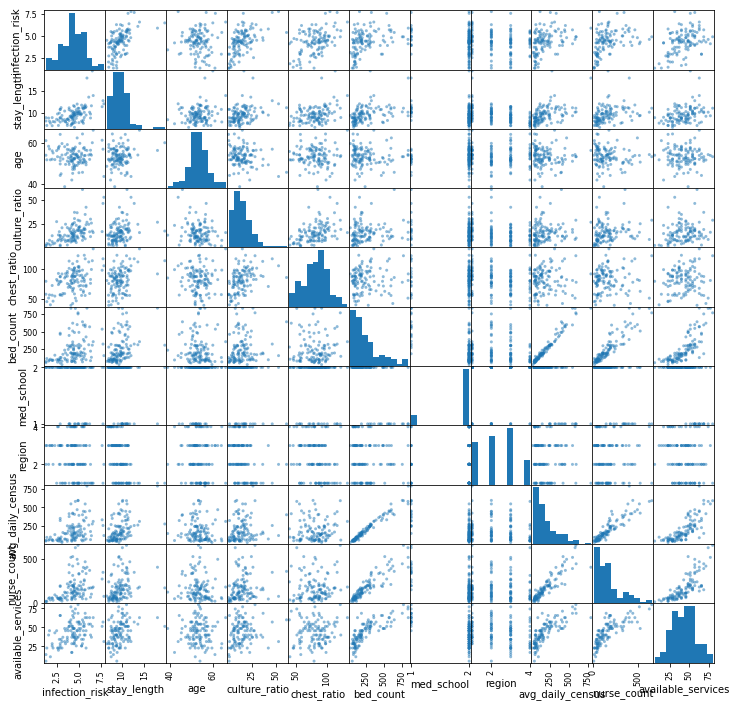

In [16]:
plt.rcParams["figure.figsize"] = (12,12)
pd.plotting.scatter_matrix(senic_df);

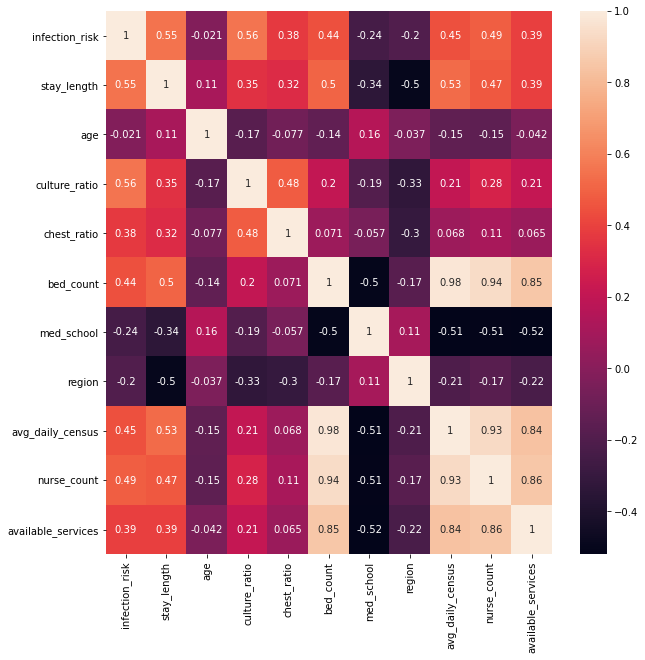

In [17]:
plt.rcParams["figure.figsize"] = (10,10)
corr_mat = senic_df.corr(method='spearman')
sns.heatmap(corr_mat, annot=True)
plt.show()

### Scatter Plot Matrix and Correlation Matrix Discussion 

Massive collinearity issues, some have very obvious relations... more beds in a hospital the more nurses. Bed count and Average Daily Census is also extremely linear. 

We looked into creating a new variables that are composed of these variables; 
i.e. nurses per bed or average daily census / number of beds

In [39]:
senic_df['nurses_per_bed'] = senic_df['nurse_count']/senic_df['bed_count']
senic_df['capacity_ratio'] = senic_df['avg_daily_census']/senic_df['bed_count']

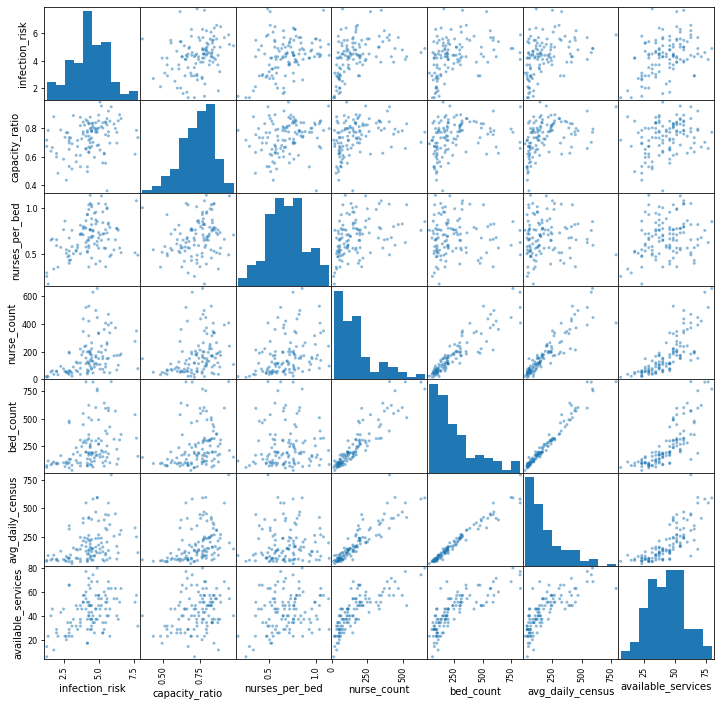

In [48]:
plt.rcParams["figure.figsize"] = (12,12)
pd.plotting.scatter_matrix(senic_df[['infection_risk','capacity_ratio','nurses_per_bed',
                                     'nurse_count','bed_count','avg_daily_census', 'available_services']]);

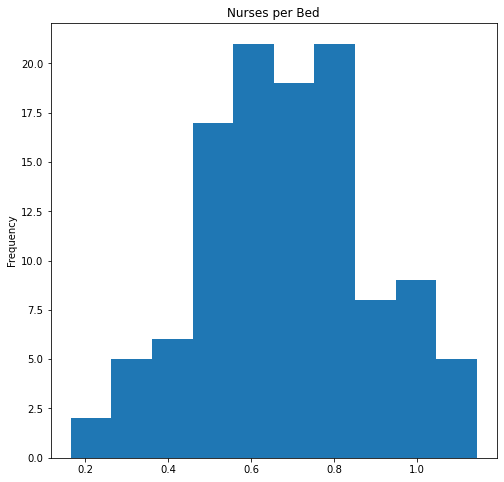

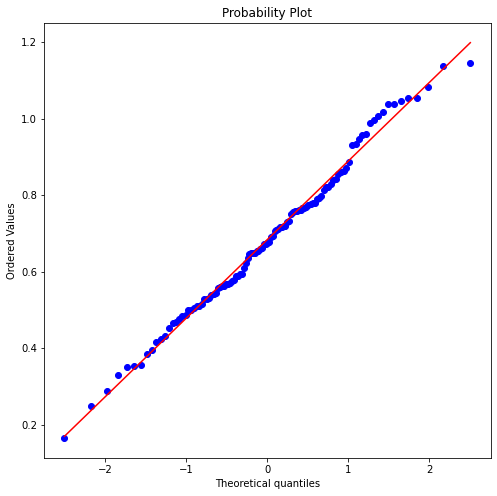

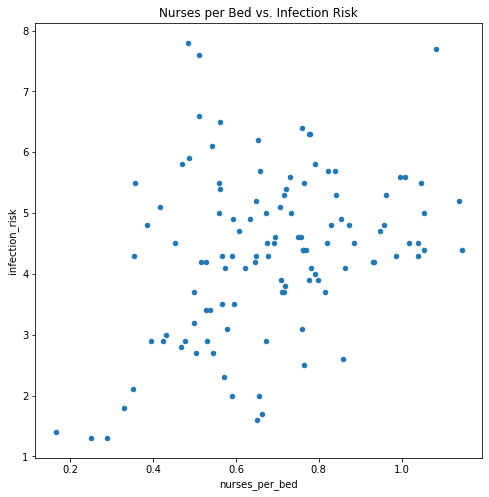

In [44]:
plt.rcParams["figure.figsize"] = (8, 8)

univariate_plot_maker(senic_df, 'infection_risk', 'nurses_per_bed', 'Infection Risk', 'Nurses per Bed')

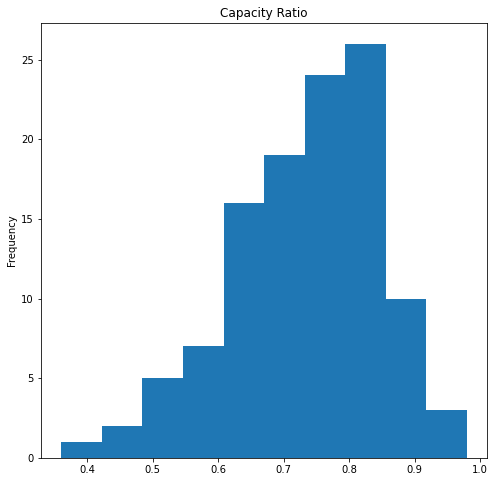

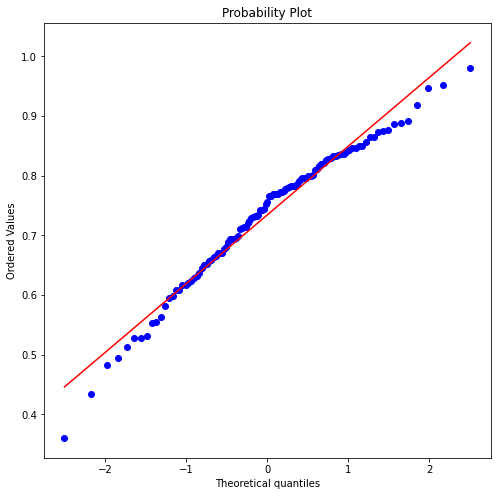

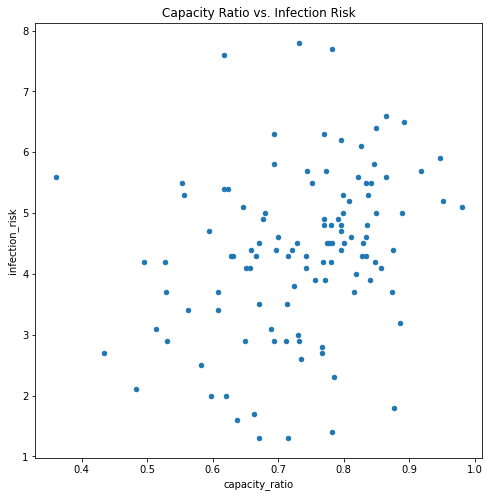

In [45]:
plt.rcParams["figure.figsize"] = (8, 8)

univariate_plot_maker(senic_df, 'infection_risk', 'capacity_ratio', 'Infection Risk', 'Capacity Ratio')

## Final Data Transformation for Regression Initial Regression

Drop columns that were determined to be scientifically extraneous and perform 1-hot encoding on categorical data

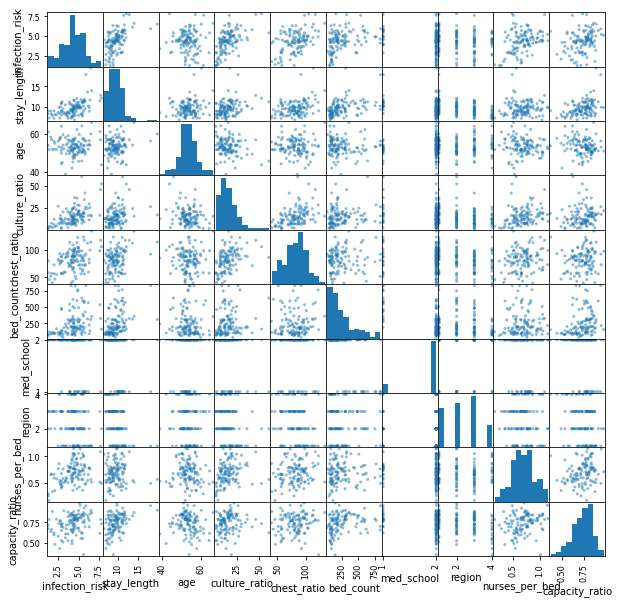

In [64]:
senic_output_df = senic_df.drop(columns=['avg_daily_census','nurse_count', 'available_services'])

pd.plotting.scatter_matrix(senic_output_df);

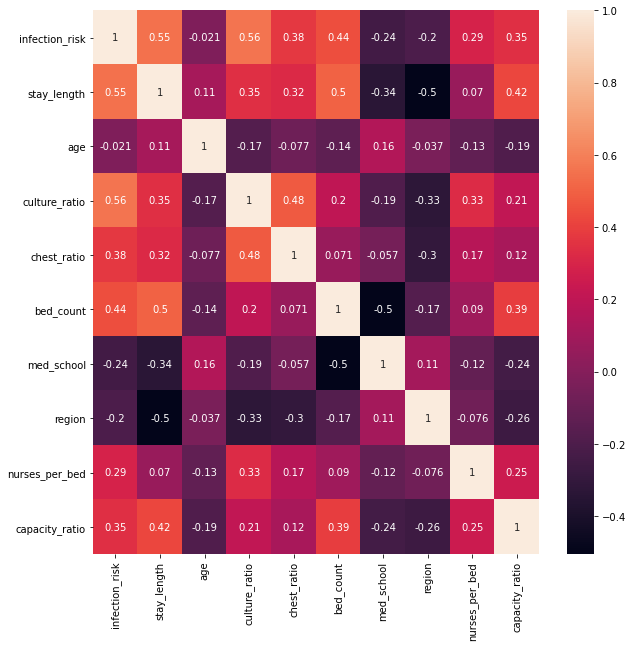

In [65]:
plt.rcParams["figure.figsize"] = (10,10)
corr_mat = senic_output_df.corr(method='spearman')
sns.heatmap(corr_mat, annot=True)
plt.show()

## VIF 

In [68]:
senic_columns = senic_output_df.columns

y = 'infection_risk'
x = " + ".join([i for i in senic_columns if  i != y])

In [87]:

_, exog = dmatrices(y + '~' + x, data=senic_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif_df = pd.DataFrame()
vif_df['VIF'] = [variance_inflation_factor(exog.values, i) for i in range(exog.shape[1])]
vif_df['variable'] = exog.columns
print(vif_df.sort_values(by='VIF',ascending=False))
# anything greater than 5! is considered high VIF
# 


          VIF        variable
0  330.284938       Intercept
1    2.257710     stay_length
5    1.760504       bed_count
6    1.630500      med_school
3    1.523274   culture_ratio
9    1.432062  capacity_ratio
7    1.422089          region
4    1.404776     chest_ratio
2    1.250484             age
8    1.178104  nurses_per_bed



## One Hot- Encode Region

In [70]:
senic_output_df = pd.concat([senic_output_df, pd.get_dummies(senic_df['region'], prefix='region')], axis=1)
senic_output_df = senic_output_df.drop(columns=['region'])

## Training Validation Split

In [137]:
# Determine size of dataset
n = senic_output_df.shape[0]
n_predictors = senic_output_df.shape[1]-1
minimum_data_size = 6*n_predictors
print(minimum_data_size)
print(n > minimum_data_size)

# determine test split size; 70% keeps enough n for the current amount of predictors
print((n*.7) > minimum_data_size)

senic_train_set = senic_output_df.sample(frac=0.7, random_state=0)
senic_validation_set = senic_output_df.drop(train_set.index)

print(senic_train_set.shape)
print(senic_validation_set.shape)


72
True
True
(79, 13)
(40, 13)


In [138]:
senic_train_set.to_csv('senic_train.csv', index=False)
senic_validation_set.to_csv('senic_validation.csv', index=False)